# Notebook Scope

This notebook represents the final step of our project, integrating various components developed in preceding notebooks. Each of these components is crucial for the functioning of our final ensemble model. You can find these notebooks in the same project folder for reference.

## Preceding Notebooks:

1. **scraper.ipynb**: 
   - Objective: To scrape celebrity names and their facial images.
   - Role: Provides the foundational data for the models.

2. **features_model.ipynb**: 
   - Objective: To build and fine-tune models that contribute to our ensemble model.
   - Key Models Developed:
     - Hair Model: Predicts hair color from a person's image.
     - Gender Model: Determines the gender from a person's image.
     - Cheekbone Model: Assesses the presence of high cheekbones in a person's image.

## Final Ensemble Model Construction:

In this notebook, we focus on creating an ensemble model that identifies the most similar celebrity to a given input image. The process is as follows:

- **Face Detection**: Utilizes a pretrained model to identify facial bounding boxes in both our dataset images and the input image.
- **Initial Similarity Assessment**: Use the Euclidean distance metric to identify the top 5 celebrities whose facial features most closely resemble those in the input image.
- **Feature-Based Refinement**:
  - Modifies the similarity score based on the Hair, Gender, and Cheekbone models.
  - Gender Matching Impact: Assigns higher weight to gender compatibility, under the assumption that the most similar celebrity will likely share the input person's gender.

## Model Validation:

To evaluate our model's effectiveness, we constructed a test dataset comprising multiple images of the same celebrity, who is also included in our main dataset. This allows us to test the model's accuracy in consistently identifying the same celebrity across different images.

In [2]:
import matplotlib.pyplot as plt
import cv2
import face_recognition
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd

### Load Hair Color Model

In [3]:
hair_color_features = ['Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']
hair_color_model = tf.keras.models.load_model('hair_model.h5')

### Load Gender Model

In [4]:
gender_features = ['Male']
gender_model = tf.keras.models.load_model('gender_model.h5')

### Load CheekBone Model

In [5]:
cheekbones_features = ['High_Cheekbones']
cheekbones_model = tf.keras.models.load_model('cheekbone_model.h5')

In [6]:
def open_image(image_path):
    """This function takes an image path and loads the image using OpenCV"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def predict_model(image_path, model):
    """
    This function takes an image path, loads the image using OpenCV, resizes it to 224x224
    pixels and then normalizes the pixel intensities to the range [0, 1]. The image is then
    converted to a NumPy array and expanded to include a batch dimension. Finally, the
    model is used to make a prediction on the input image.
    """
    image = open_image(image_path)

    # We resize the image to 128x128 pixels to keep the input size of the model coherent with the training phase of the models.
    image = cv2.resize(image, (128, 128))
    
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    return np.argmax(prediction)

### Load all the celebrity images

We are currently processing images from the **image folder**. Each image file is named after a celebrity.

1. **Compute Face Encodings:** For each image, we calculate the face encodings.
2. **Face Verification:** 
   - If exactly **one face** is found, we retain the image.
   - If not, the image is excluded from our dataset.

This is necessary because our scraping from Wikipedia wasn't flawless. Sometimes, the primary image does not showcase the celebrity's face.

In [7]:
images_paths = [f"images/{x}" for x in os.listdir('images')]

dataset_face_encodings = []
final_images_paths = []

for image_path in images_paths:
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        face_encodings = face_recognition.face_encodings(image)
    except:
        continue

    # We only care about the first face in the image. If there is no face in the image, it will not be added to the dataset.
    if len(face_encodings) == 1:
        dataset_face_encodings.append(face_encodings[0])
        final_images_paths.append(image_path)

dataset_face_encodings = np.array(dataset_face_encodings)
images_paths = final_images_paths
celebrity_names = [x.split('.jpg')[0].split('/')[-1] for x in images_paths]

print("Dataset face encodings shape: ", dataset_face_encodings.shape)

Dataset face encodings shape:  (1021, 128)


### Predict Features

We predict the gender, hair color and hair style for each celebrity image in the dataset.

In [8]:
images = []
for image_path in images_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    images.append(image)

images = np.array(images)


gender_predictions     = np.where(gender_model.predict(images) >= 0.5, 1, 0)
hair_color_predictions = np.argmax(hair_color_model.predict(images), axis=1)
cheekbones_predictions = np.argmax(cheekbones_model.predict(images), axis=1)

32/32 [==============================] - 3s 71ms/step


We check that the model predictions are working as expected by showing some images and the predicted values.

Image name:  Thora_Birch
Gender: Woman
Hair color: Blond_Hair
Cheekbones: Not High Cheekbones


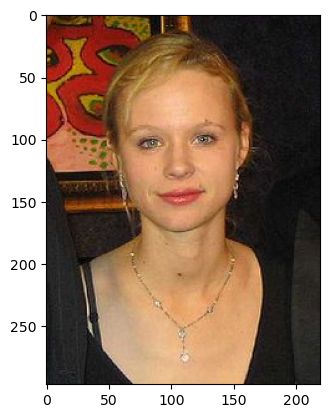

In [9]:
random_index = random.randint(0, len(images_paths) - 1)
image_path = images_paths[random_index]
image_name = image_path.split('.')[0].split('/')[-1]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gender = "Male" if gender_predictions[random_index] == 1 else "Woman"
hair_color = hair_color_features[hair_color_predictions[random_index]]
cheekbones = "High Cheekbones" if cheekbones_predictions[random_index] == 1 else "Not High Cheekbones"

print("Image name: ", image_name)
print(f"Gender: {gender}")
print(f"Hair color: {hair_color}")
print(f"Cheekbones: {cheekbones}")

plt.imshow(image)
plt.show()


In [10]:
def face_distances(face_encodings, face_to_compare):
    """
    Given a list of face encodings, compare them to a known face encoding and get a euclidean distance
    for each comparison face. The distance tells you how similar the faces are.
    """
    if len(face_encodings) == 0:
        return np.empty((0))
    return np.linalg.norm(face_encodings - face_to_compare, axis=1)


def most_similar_celebrity(input_image_path, dataset_encodings, dataset_names, images, ensemble=False):
    image = cv2.imread(input_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_face_encodings = face_recognition.face_encodings(image)
    
    if len(input_face_encodings) == 0:
        print("No faces found in the input image.")
        return None, None
    
    if len(input_face_encodings) > 1:   
        print("Multiple faces found in the input image. Please use images with only one face.")
        return None, None

    distances = face_distances(dataset_encodings, input_face_encodings)
    df = pd.DataFrame(zip(distances, range(len(distances))), columns=['distance', 'index']).sort_values(by='distance').head(6)

    if not ensemble:
        return dataset_names[int(df.iloc[1]['index'])]

    images_batch = np.stack([images[i] for i in df['index']])
    df['gender'] = np.where(gender_model.predict(images_batch, verbose=0) >= 0.5, 1, 0)
    df['hair_color'] = np.argmax(hair_color_model.predict(images_batch, verbose=0), axis=1)
    df['cheekbones'] = np.where(cheekbones_model.predict(images_batch, verbose=0) >= 0.5, 1, 0)

    input_data = df.iloc[0]
    df = df.iloc[1:]

    df['same_gender'] = np.where(df['gender'] == input_data['gender'], 1, 0)
    df['same_hair_color'] = np.where(df['hair_color'] == input_data['hair_color'], 1, 0)
    df['same_cheekbones'] = np.where(df['cheekbones'] == input_data['cheekbones'], 1, 0)

    df['new_distance'] = df['distance']
    df['new_distance'] += 0.2  * (1 - df['same_gender'])
    df['new_distance'] += 0.03 * (1 - df['hair_color'])
    df['new_distance'] += 0.02 * (1 - df['same_cheekbones'])
    df['name'] = [dataset_names[int(i)] for i in df['index']]

    df.sort_values(by=['new_distance'], ascending=True, inplace=True)

    return dataset_names[int(df.iloc[0]['index'])], df


Here we test our model on the dataset images, looking which celebrities look alike.

You can run the cell below as many times as you want and you will see different celebrities and who they look like based on our model.

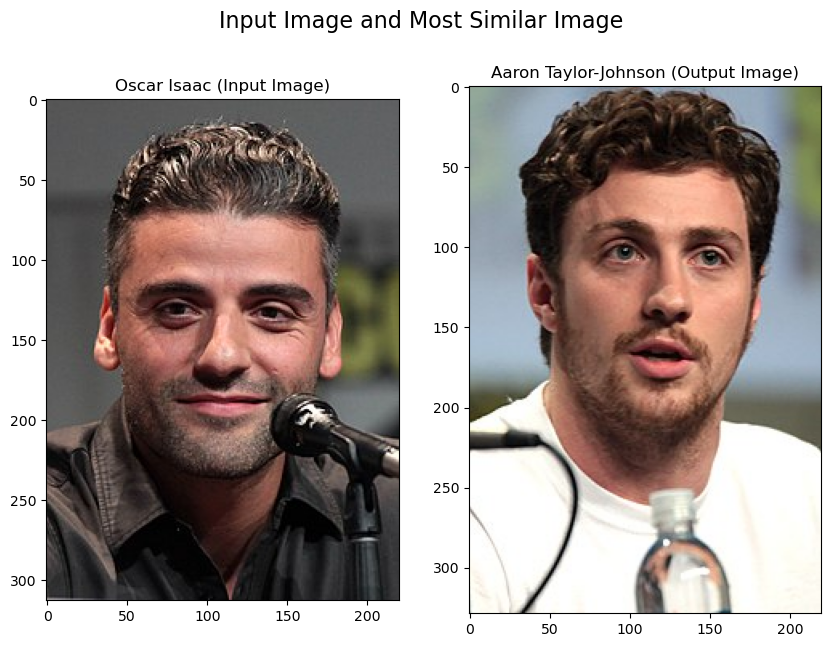

In [28]:
input_image_path = random.choice(images_paths)

most_similar_ensamble, _ = most_similar_celebrity(input_image_path, dataset_face_encodings, celebrity_names, images, ensemble=True)

input_image = open_image(input_image_path)
most_similar_image_ensamble = open_image(f'images/{most_similar_ensamble}.jpg')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(input_image)
ax[0].set_title(input_image_path.split('/')[-1].split('.jpg')[0].replace('_', ' ') + " (Input Image)") 

ax[1].imshow(most_similar_image_ensamble)
ax[1].set_title(most_similar_ensamble.replace('_', ' ') + " (Output Image)")

fig.suptitle("Input Image and Most Similar Image", verticalalignment='top', fontsize=16)
fig.subplots_adjust(top=1.17)
plt.show()

## Interact with the Model

In [12]:
def get_most_similar(path, encodings, names, images, ensemble=True):
    try:
        input_encoding = face_recognition.face_encodings(open_image(path))[0]
    except:
        print("No faces found in the input image.")
        return None, None
    encodings = np.vstack([encodings, input_encoding])
    names = np.hstack([names, ['Input Image']])
    image = open_image(path)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    images = np.vstack([images, np.expand_dims(image, axis=0)])

    return most_similar_celebrity(path, encodings, names, images, ensemble)


def plot_most_similar(path, encodings, names, images):
    most_similar_ensamble, _ = get_most_similar(path, encodings, names, images)
    if most_similar_ensamble is None:
        return

    input_image = open_image(path)
    most_similar_image_ensamble = open_image(f'images/{most_similar_ensamble}.jpg')

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(input_image)
    ax[0].set_title("Input Image") 

    ax[1].imshow(most_similar_image_ensamble)
    ax[1].set_title(most_similar_ensamble.replace('_', ' '))

    fig.suptitle("Input Image and Most Similar Image", verticalalignment='top', fontsize=16)
    fig.subplots_adjust(top=1.17)
    plt.show()

In [ ]:
path_to_your_image = '...'
path_to_your_image = 'AA-not_needed/ste.jpg'


plot_most_similar(path_to_your_image, dataset_face_encodings, celebrity_names, images)

## Model Validation Process

### Objective
The primary goal of our validation process is to assess the model's accuracy in recognizing and matching different images of the same individuals. Our hypothesis is that a "good" model will consistently identify the same person as the most similar across various images.

### Methodology
- **Creation of a Test Dataset**: We have created a new dataset specifically for this validation. This dataset comprises multiple images of the same celebrities, ensuring a diverse range of photos for each individual. After creating this dataset we merge it with the base dataset that we have.
  
- **Validation Procedure**: The model's performance is evaluated based on its ability to correctly match different images of the same person. The key metric here is the frequency with which the model accurately identifies the most similar image as one of the same person.

### Evaluation Metrics
- **Accuracy Rate**: The percentage of instances where the model correctly identifies the same person as the most similar one across different images.
  


### Validation of the ensamble model

In [14]:
correct = 0
test_images_paths = [f"test_images/{x}" for x in os.listdir('test_images') if x.split('.')[-1] == 'jpg']
for test_path in test_images_paths:
    most_similar_ensemble, df = get_most_similar(test_path, dataset_face_encodings, celebrity_names, images)
    if most_similar_ensemble is None:
        continue

    celebrity = "_".join(test_path.split('.jpg')[0].split('/')[-1].split('_')[:-1])
    match_info = test_path.split('.jpg')[0].split('/')[-1] + ' -> ' + most_similar_ensemble
    
    if celebrity in most_similar_ensemble:
        print(f"\033[92m{match_info}\033[0m")  # Green text for correct matches
        correct += 1
    else:
        print(f"\033[91m{match_info}\033[0m")

Steve_Carell_2 -> Steve_Carell
Neil_Patrick_Harris_3 -> Neil_Patrick_Harris
Neil_Patrick_Harris_2 -> Neil_Patrick_Harris
Margot_Robbie_1 -> Margot_Robbie
Ezio_Greggio_2 -> Bobby_Charlton
Benedict_Cumberbatch_1 -> Benedict_Cumberbatch
Steve_Carell_3 -> Steve_Carell
Steve_Carell_1 -> Steve_Carell
Margot_Robbie_3 -> Margot_Robbie
Neil_Patrick_Harris_1 -> Neil_Patrick_Harris
Margot_Robbie_2 -> Margot_Robbie
Ezio_Greggio_1 -> Totò
Benedict_Cumberbatch_2 -> Benedict_Cumberbatch
Elon_Musk_1 -> Elon_Musk
Elon_Musk_2 -> Elon_Musk
Alfre_1 -> Alfre
Adam_Sandler_1 -> Adam_Sandler
Adam_Sandler_3 -> Adam_Sandler
Alfre_2 -> Alfre
Adam_Sandler_2 -> Adam_Sandler
Taylor_Swift_3 -> Taylor_Swift
Johnny_Depp_1 -> Johnny_Depp
Taylor_Swift_2 -> Taylor_Swift
Johnny_Depp_2 -> Johnny_Depp
Johnny_Depp_3 -> Johnny_Depp
Taylor_Swift_1 -> Taylor_Swift
Morgan_Freeman_3 -> Morgan_Freeman
Morgan_Freeman_2 -> Morgan_Freeman
Morgan_Freeman_1 -> Morgan_Freeman
Peter_Dinklage_2 -> Hugo_Weaving
Peter_Dinklage_1 -> Sean_Con

In [15]:
print(f"\nCorrect predictions: {correct}")
print(f"Total predictions: {len(test_images_paths)}")
print(f"Accuracy: {correct / len(test_images_paths) * 100:.2f}%")


Correct predictions: 27
Total predictions: 31
Accuracy: 87.10%


Let's see some of the errors that we got...

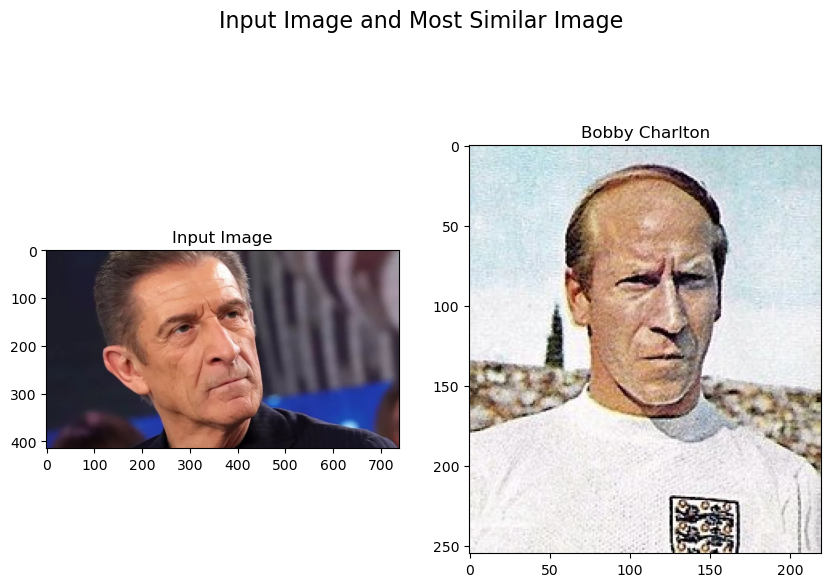

In [16]:
plot_most_similar('test_images/Ezio_Greggio_2.jpg', dataset_face_encodings, celebrity_names, images)

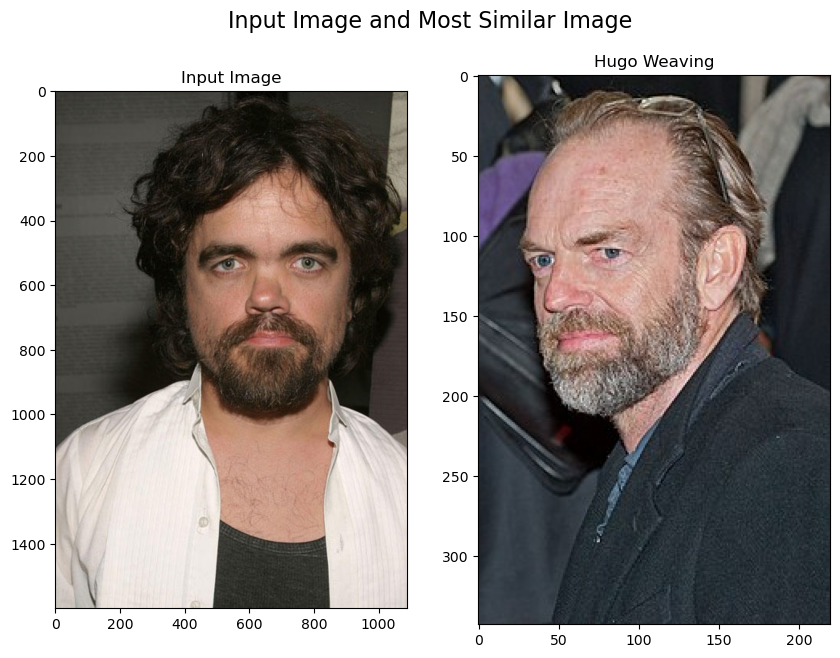

In [17]:
plot_most_similar('test_images/Peter_Dinklage_2.jpg', dataset_face_encodings, celebrity_names, images)

Even though the model makes some mistakes when predicting the most similar celebrity by not indicating the celebrity itselfes, it still makes good guesses that looks similar to the original celebrity image.

### Validation of the Baseline model without ensemble

In [18]:
correct = 0
test_images_paths = [f"test_images/{x}" for x in os.listdir('test_images') if x.split('.')[-1] == 'jpg']
for test_path in test_images_paths:
    most_similar_ensemble = get_most_similar(test_path, dataset_face_encodings, celebrity_names, images, ensemble=False)
    if most_similar_ensemble is None:
        continue

    celebrity = "_".join(test_path.split('.jpg')[0].split('/')[-1].split('_')[:-1])
    match_info = test_path.split('.jpg')[0].split('/')[-1] + ' -> ' + most_similar_ensemble
    
    if celebrity in most_similar_ensemble:
        print(f"\033[92m{match_info}\033[0m")  # Green text for correct matches
        correct += 1
    else:
        print(f"\033[91m{match_info}\033[0m")

Steve_Carell_2 -> Steve_Carell
Neil_Patrick_Harris_3 -> Neil_Patrick_Harris
Neil_Patrick_Harris_2 -> Neil_Patrick_Harris
Margot_Robbie_1 -> Margot_Robbie
Ezio_Greggio_2 -> Ezio_Greggio
Benedict_Cumberbatch_1 -> Benedict_Cumberbatch
Steve_Carell_3 -> Steve_Carell
Steve_Carell_1 -> Steve_Carell
Margot_Robbie_3 -> Margot_Robbie
Neil_Patrick_Harris_1 -> Neil_Patrick_Harris
Margot_Robbie_2 -> Margot_Robbie
Ezio_Greggio_1 -> Ezio_Greggio
Benedict_Cumberbatch_2 -> Benedict_Cumberbatch
Elon_Musk_1 -> Elon_Musk
Elon_Musk_2 -> Elon_Musk
Alfre_1 -> Alfre
Adam_Sandler_1 -> Adam_Sandler
Adam_Sandler_3 -> Adam_Sandler
Alfre_2 -> Alfre
Adam_Sandler_2 -> Adam_Sandler
Taylor_Swift_3 -> Taylor_Swift
Johnny_Depp_1 -> Johnny_Depp
Taylor_Swift_2 -> Charlize_Theron
Johnny_Depp_2 -> Johnny_Depp
Johnny_Depp_3 -> Johnny_Depp
Taylor_Swift_1 -> Taylor_Swift
Morgan_Freeman_3 -> Morgan_Freeman
Morgan_Freeman_2 -> Morgan_Freeman
Morgan_Freeman_1 -> Morgan_Freeman
Peter_Dinklage_2 -> Hugo_Weaving
Peter_Dinklage_1 ->

In [19]:
print(f"\nCorrect predictions: {correct}")
print(f"Total predictions: {len(test_images_paths)}")
print(f"Accuracy: {correct / len(test_images_paths) * 100:.2f}%")


Correct predictions: 28
Total predictions: 31
Accuracy: 90.32%


When running the test set with the model that is using just the face similarity it correctly guesses the most similar person 1 time more than when using the ensemble model.

This is a very similar result and even though it seems like the baseline model is perfoming better than the ensemble one, the performance is very similar and the ensemble model might catch better similarities when comparing images between different people.

When testing our model on other images that we could not fit into the test set since they are subjective we saw an improvement using the ensemble model.

In [20]:
input_image_path = 'images/James_Woods.jpg'

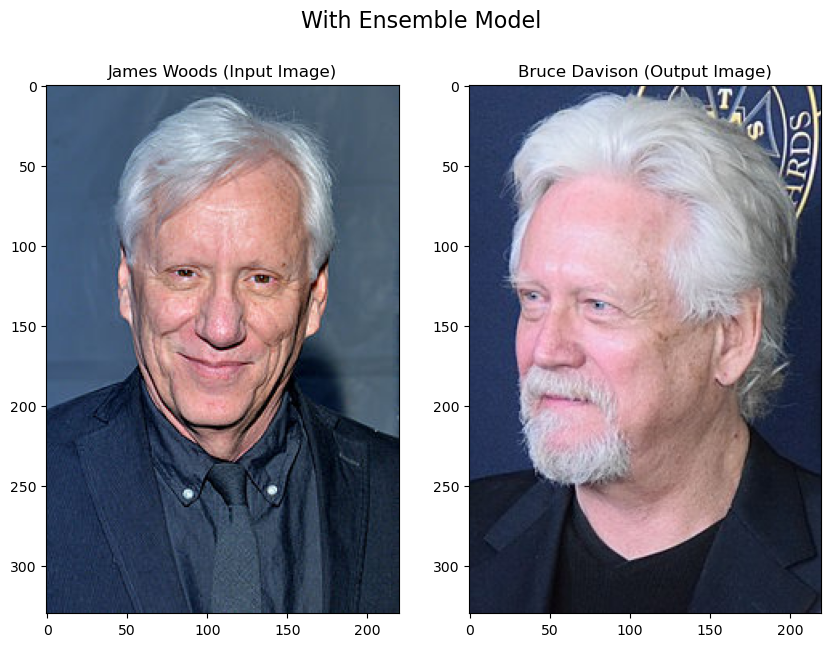

In [21]:
most_similar_ensamble, _ = most_similar_celebrity(input_image_path, dataset_face_encodings, celebrity_names, images, ensemble=True)

input_image = open_image(input_image_path)
most_similar_image_ensamble = open_image(f'images/{most_similar_ensamble}.jpg')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(input_image)
ax[0].set_title(input_image_path.split('/')[-1].split('.jpg')[0].replace('_', ' ') + " (Input Image)") 

ax[1].imshow(most_similar_image_ensamble)
ax[1].set_title(most_similar_ensamble.replace('_', ' ') + " (Output Image)")

fig.suptitle("With Ensemble Model", verticalalignment='top', fontsize=16)
fig.subplots_adjust(top=1.17)
plt.show()

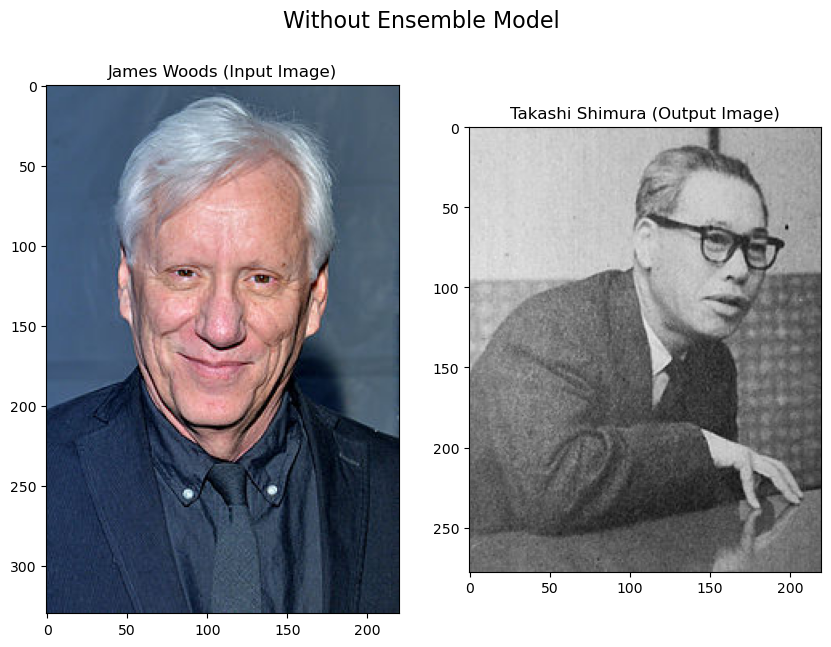

In [22]:
most_similar_ensamble = most_similar_celebrity(input_image_path, dataset_face_encodings, celebrity_names, images, ensemble=False)

input_image = open_image(input_image_path)
most_similar_image_ensamble = open_image(f'images/{most_similar_ensamble}.jpg')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(input_image)
ax[0].set_title(input_image_path.split('/')[-1].split('.jpg')[0].replace('_', ' ') + " (Input Image)") 

ax[1].imshow(most_similar_image_ensamble)
ax[1].set_title(most_similar_ensamble.replace('_', ' ') + " (Output Image)")

fig.suptitle("Without Ensemble Model", verticalalignment='top', fontsize=16)
fig.subplots_adjust(top=1.17)
plt.show()

In [23]:
image = cv2.imread(input_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))
image = image / 255.0

hair_color_predictions = hair_color_model.predict(image.reshape(1, 128, 128, 3), verbose=0)
hair_color = hair_color_features[hair_color_predictions.argmax(axis=1)[0]]

print(f"Hair color: {hair_color}")

Hair color: Gray_Hair


The above is an example showing a case where the ensemble model is performing better than the baseline model.

In this example the **hair_model** predicts the hair of the input image to be gray, increasing the face distance of every celebrity without gray hair. This effect makes the prediction of the baseline model change since the baseline model indicates as the most similar celeberity a person without gray hair.

The resulting celebrity that the ensemble model suggest as the most similar one is better and objectively more similar compared to the model without ensemble.